In [139]:
import sys
sys.path.insert(0, '../python/casadi_f16')
import f16
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

import analysis
from analysis import loop_analysis, rlocus, bode

In [140]:
!pip install casadi

# Roll Autopilot Design

* See Roll Autopilot design example in section 4.6 of Stevens and Lewis.
* Homework 1: Due 8/30 @  11 pm: Trim the F16 model around a VT=550 ft/s, 20 deg/s yaw rate turn.
* Find the A, B, C, D matrices for the state space model.
* Find the transfer function for the aileron to roll rate (P).
* Design a PID controller attempting to meet the following specifications
    * Maximum overshoot: 20%
    * Rise time: 0.1 second
    * Settling time 1 second
* Simulate and plot the response of your controlled system and the linear model for a step response in roll rate of 10 deg/s and 100 deg/s. How do the nonlinear and linear responses compare?
* Using git, fork aae497-f16 on github. Complete the homework. Submit your homework via pull request on aae497-f16.

In [141]:
p = f16.Parameters()
x0, u0 = f16.trim(x=f16.State(VT=550), p=p, phi_dot=0, theta_dot=0, psi_dot=20.0*np.pi/180, gam=0)

In [142]:
x0

State(VT=550, alpha=DM(0.251546), beta=DM(0.00040503), phi=DM(1.41001), theta=DM(0.0415563), psi=0, P=DM(-0.0145017), Q=DM(0.344266), R=DM(0.0558364), p_N=0, p_E=0, alt=0, power=DM(86.8792), ail_deg=DM(0.0832868), elv_deg=DM(-1.41359), rdr_deg=DM(-0.3512))

In [143]:
u0

Control(thtl=DM(0.939641), ail_cmd_deg=DM(0.0832868), elv_cmd_deg=DM(-1.41359), rdr_cmd_deg=DM(-0.3512))

In [144]:
ss = f16.linearize(x0, u0, p)
#ss

In [145]:
#sys = control.ss2tf(ss.A,ss.B,ss.C,ss.D);
#sys = control.minreal(sys,1e-7);
#sys

In [146]:
def select(n, i):
    D = np.zeros((1, n))
    D[0, i] = 1
    return control.ss([], [], [], D)

In [147]:
s = control.tf([1, 0], [0, 1])
G = -(180/np.pi)*ss.sub_system(x=['alpha', 'Q', 'elv_deg'],
                  u=['elv_cmd_deg'], y=['alpha', 'Q']).to_control()
sys3 = control.feedback(G, 0.2*10/(s+10)*select(2, 0))
sys3


A = [[-1.15177248e+00  9.03393838e-01 -2.34025343e-03  0.00000000e+00]
 [ 3.98296410e+00 -1.48073989e+00 -2.35589930e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.02020000e+01  2.31497868e+03]
 [ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e+01]]

B = [[    0.        ]
 [    0.        ]
 [-1157.48933772]
 [    0.        ]]

C = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]]

D = [[0.]
 [0.]]

3 states have been removed from the model


[-21, 0, -8, 8]

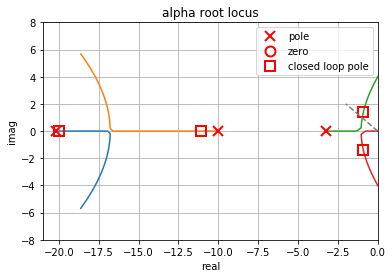

In [148]:
from analysis import rlocus
H = (10/(s+10))*select(2, 0)
plt.figure()
kalpha = 0.2
rlocus('alpha', control.minreal(H*G), kvect=np.linspace(0, 10, 1000), k=kalpha*2);
plt.plot([0, -2], [0, 2], '--')
plt.axis([-21, 0, -8, 8])

[-20, 0, -5, 5]

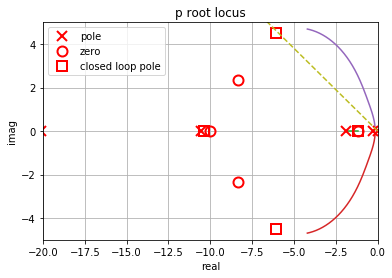

In [149]:
plt.figure()
sys3 = control.feedback(G, kalpha*(10/(s+10))*select(2, 0))
k = 2.2;
rlocus('p', (s**2*0.06+s+4.5)/s*sys3[1, 0], kvect=np.linspace(0, 1, 1000), k=k)
plt.plot([0, -10], [0, 10*np.cos(0.707)], '--')
plt.axis([-20, 0, -5, 5])

In [150]:
#bode('test', (s+5)/s*sys3[1, 0], omega=np.logspace(-2, 4), margins=True, Hz=True)

In [151]:
sys4 = control.feedback((s**2*0.06+s+4.5)*k/s*sys3[1, 0], 1)
sys4

#def f_control(t, x, x_dot, x_int):
#    return f16.Control(
#        thtl=u0.thtl,
#        ail_cmd_deg=u0.ail_cmd_deg,
#        elv_cmd_deg=u0.elv_cmd_deg + x.alpha*k + x_dot.alpha*0.06*k + x_int.alpha*4.5*k,
#        rdr_cmd_deg=u0.rdr_cmd_deg)

In [152]:
#By frmdstryr | https://sourceforge.net/p/python-control/discussion/1022992/thread/3d038097/
def step_info(t,yout):
    print("Overshoot    :" + str((yout.max()/yout[-1]-1)*100) + "%")
    print("Rise Time    :" + str(t[next(i for i in range(0,len(yout)-1) if yout[i]>yout[-1]*.90)]-t[0]))
    print("Settling Time:" + str(t[next(len(yout)-i for i in range(2,len(yout)-1) if abs(yout[-i]/yout[-1])>1.02)]-t[0]))

Overshoot    :7.21002358449685%
Rise Time    :0.08163265306122448
Settling Time:0.5510204081632653


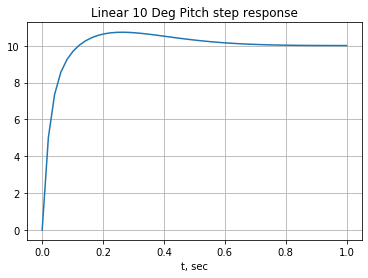

In [154]:
analysis.step_reponse('Linear 10 Deg Pitch',10*sys4,np.linspace(0,1));
t, y = control.step_response(sys4,np.linspace(0,1));
step_info(t,y)

#res = f16.simulate(x0, f_control, p, 0, 20, 0.005)
#plt.plot(res['t'], np.rad2deg(res['x'][:, f16.State().name_to_index('alpha')]))
#plt.xlabel('t ,sec')
#plt.ylabel(r'$\alpha$, deg')
#plt.grid()
#plt.title('Nonlinear 10 Deg Pitch Step Response')

Overshoot    :7.21002358449685%
Rise Time    :0.08163265306122448
Settling Time:0.5510204081632653


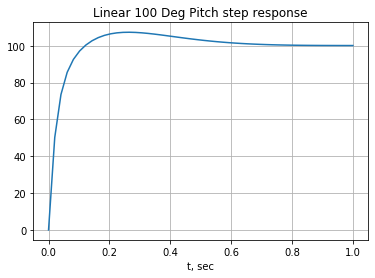

In [138]:
analysis.step_reponse('Linear 100 Deg Pitch',sys4*100,np.linspace(0,1));
t, y = control.step_response(sys4,np.linspace(0,1));
step_info(t,y)